In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
device = torch.device("cuda", 1)

In [2]:
import numpy as np
import scipy
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline
NOISE_DIM = 5
def sample_noise(N):
    return np.random.uniform(size=(N,NOISE_DIM)).astype(np.float32)

In [29]:
class Generator(nn.Module):
    def __init__(self, noise_dim, out_dim, hidden_dim=100, input_param=1):
        super(Generator, self).__init__()
        
        self.fc1 = nn.Linear(noise_dim + input_param, hidden_dim)
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0.0)
        
        self.fc2 = nn.Linear(hidden_dim + input_param, hidden_dim)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0.0)
        
        self.fc3 = nn.Linear(hidden_dim + input_param, hidden_dim)
        nn.init.xavier_normal_(self.fc3.weight)
        nn.init.constant_(self.fc3.bias, 0.0)
        
        # heads
        self.fc_head_11 = nn.Linear(hidden_dim + input_param, hidden_dim)
        nn.init.xavier_normal_(self.fc_head_11.weight)
        nn.init.constant_(self.fc_head_11.bias, 0.0)
        
        self.fc_head_12 = nn.Linear(hidden_dim + input_param, out_dim)
        nn.init.xavier_normal_(self.fc_head_12.weight)
        nn.init.constant_(self.fc_head_12.bias, 0.0)
        
        # heads
        self.fc_head_21 = nn.Linear(hidden_dim + input_param, hidden_dim)
        nn.init.xavier_normal_(self.fc_head_21.weight)
        nn.init.constant_(self.fc_head_21.bias, 0.0)
        
        self.fc_head_22 = nn.Linear(hidden_dim + input_param, out_dim)
        nn.init.xavier_normal_(self.fc_head_22.weight)
        nn.init.constant_(self.fc_head_22.bias, 0.0)

    def forward(self, z, params, mode):
        """
            Generator takes a vector of noise and produces sample
        """
        #z = torch.cat([z, params.repeat(z.shape[0], 1)], dim=1)
        z = torch.cat([z, params], dim=1)
        h1 = torch.tanh(self.fc1(z))
        h2 = torch.tanh(self.fc2(torch.cat([h1, params], dim=1)))
        h3 = torch.tanh(self.fc3(torch.cat([h2, params], dim=1)))
        y_gen = torch.tanh(self.fc_head_11(torch.cat([h3, params], dim=1))) if mode=="01" else torch.tanh(self.fc_head_21(torch.cat([h3, params], dim=1)))
        y_gen = self.fc_head_12(torch.cat([y_gen, params], dim=1)) if mode=="01" else self.fc_head_22(torch.cat([y_gen, params], dim=1))
        return y_gen

In [30]:
class Discriminator(nn.Module):
    def __init__(self, in_dim, hidden_dim=100, input_param=1):
        super(Discriminator, self).__init__()
        
        self.fc1 = nn.Linear(in_dim + input_param, hidden_dim)
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0.0)
        
        self.fc2 = nn.Linear(hidden_dim + input_param, hidden_dim)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0.0)
        
        self.fc3 = nn.Linear(hidden_dim + input_param, hidden_dim)
        nn.init.xavier_normal_(self.fc3.weight)
        nn.init.constant_(self.fc3.bias, 0.0)
        
        self.fc4 = nn.Linear(hidden_dim + input_param, hidden_dim)
        nn.init.xavier_normal_(self.fc4.weight)
        nn.init.constant_(self.fc4.bias, 0.0)
        
        self.fc5 = nn.Linear(hidden_dim + input_param, 1)
        nn.init.xavier_normal_(self.fc5.weight)
        nn.init.constant_(self.fc5.bias, 0.0)
        
    def forward(self, x, params):
        #x = torch.cat([x, params.repeat(x.shape[0], 1)], dim=1)
        x = torch.cat([x, params], dim=1)
        h1 = torch.tanh(self.fc1(x))
        h2 = torch.tanh(self.fc2(torch.cat([h1, params], dim=1)))
        h3 = F.leaky_relu(self.fc3(torch.cat([h2, params], dim=1)))
        h4 = F.leaky_relu(self.fc4(torch.cat([h3, params], dim=1)))
        score = self.fc5(torch.cat([h4, params], dim=1))
        return score

In [34]:
generator = Generator(NOISE_DIM, out_dim = 1).to(device)
discriminator = Discriminator(in_dim = 1).to(device)

lr = 0.0001

g_optimizer = optim.Adam(generator.parameters(),     lr=lr, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [6]:
def g_loss(discrim_output):
    loss = - discrim_output.mean()
    return loss


def d_loss(discrim_output_gen, discrim_output_real):
    loss = - (discrim_output_real.mean() - discrim_output_gen.mean())
    return loss

In [7]:
# # alphas, digits from normal distbution for alpha \in [0,1]
batch_alpha_01, batch_data_01 = np.load("alpha_01_train.npy"), np.load("data_01_train.npy")
valid_alpha_01, valid_data_01 = np.load("alpha_01_val.npy"), np.load("data_01_val.npy")

# # alphas, digits from normal distbution for alpha \in [0,2]
batch_alpha_02, batch_data_02 = np.load("alpha_02_train.npy"), np.load("data_02_train.npy")
valid_alpha_02, valid_data_02 = np.load("alpha_02_val.npy"), np.load("data_02_val.npy")

# # alphas, digits from normal distbution for alpha \in [1,2]
alpha_12 = np.load("alpha_12_val.npy")
data_12 = np.load("data_12_val.npy")

In [8]:
batch_alpha_01.shape, batch_data_01.shape

((100000, 256, 1), (100000, 256, 1))

In [9]:
def iterate_minibatches(batch_alpha, batch_data):
    rp = np.random.permutation(len(batch_alpha))
    for x, y in zip(batch_alpha[rp], batch_data[rp]):
        yield torch.Tensor(x.reshape((len(x), 1))).to(device), torch.Tensor(y).to(device)

# def iterate_minibatches(batch_alpha, batch_data, batch_size=128):
#     batch_alpha = batch_alpha.reshape(-1, 1)
#     batch_data = batch_data.reshape(-1, 1)
    
#     rp = np.random.permutation(len(batch_alpha))
#     batch_alpha = batch_alpha[rp]
#     batch_data = batch_data[rp]
#     for i in range(0, len(batch_alpha), batch_size):
#         yield torch.Tensor(batch_alpha[i: i+batch_size]).to(device), torch.Tensor(batch_data[i: i+batch_size]).to(device)

In [10]:
fixed_noise = torch.Tensor(sample_noise(10000)).to(device)

In [11]:
from torch import autograd
LAMBDA = 10
def calc_gradient_penalty(real_data, fake_data, input_alpha):
    alpha = torch.rand(real_data.shape[0], 1).expand(real_data.size()).to(device)

    interpolates = alpha * real_data + ((1 - alpha) * fake_data)

    interpolates = autograd.Variable(interpolates, requires_grad=True)

    disc_interpolates = discriminator(interpolates.to(device), input_alpha.to(device))

    gradients = autograd.grad(outputs=disc_interpolates.to(device), inputs=interpolates.to(device),
                              grad_outputs=torch.ones(
                                  disc_interpolates.size()).to(device),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty

In [35]:
from IPython import display
num_epochs = 100


def update_gen(input_alpha, input_data, mode, k_g):
    for _ in range(k_g):
        # Sample noise
        noise = torch.Tensor(sample_noise(len(input_data))).to(device)

        # Do an update
        data_gen = generator(noise, input_alpha, mode=mode)
        loss = g_loss(discriminator(data_gen, input_alpha))
        g_optimizer.zero_grad()
        loss.backward()
        g_optimizer.step()
        
    return loss.item()
    
def update_disc(input_alpha, input_data, mode, k_d):
    for _ in range(k_d):
        # Sample noise
        noise = torch.Tensor(sample_noise(len(input_data))).to(device)

        # Do an update
        inp_data = input_data.to(device)
        data_gen = generator(noise, input_alpha, mode=mode)

#         loss = d_loss(discriminator(data_gen, input_alpha), discriminator(inp_data, input_alpha))
#         d_optimizer.zero_grad()
#         loss.backward()
#         d_optimizer.step()
#         grad_penalty = calc_gradient_penalty(data_gen.data, inp_data.data, input_alpha)
#         loss += grad_penalty

        loss1 = discriminator(data_gen, input_alpha).mean()
    
        d_optimizer.zero_grad()
        loss1.backward()
        d_optimizer.step()
        
        loss2 = -discriminator(inp_data, input_alpha).mean()
    
        d_optimizer.zero_grad()
        loss2.backward()
        d_optimizer.step()
                           
        for p in discriminator.parameters():
            p.data.clamp_(-0.01, 0.01)

    return loss1.item() + loss2.item()


def run_training():
    k_d, k_g = 4, 1

    dis_losses, gen_losses = {"01": [], "02": [], "12": []}, {"01": [], "02": [], "12": []}
    wasserstein_ds = {"01": [], "02": [], "12": []}

    try:
        for epoch in range(num_epochs):
            dis_epoch_loss = {"01": [], "02": [], "12": []}
            gen_epoch_loss = {"01": [], "02": [], "12": []}
            
            train_gen_01 = iterate_minibatches(batch_alpha_01, batch_data_01)
            train_gen_02 = iterate_minibatches(batch_alpha_02, batch_data_02)
                        
            num_iter = 0
            while True:
                num_iter += 1
                try:
                    input_alpha, input_data = next(train_gen_01)
                except StopIteration:
                    break
                    
                # Optimize D
                dis_epoch_loss["01"].append(update_disc(input_alpha, input_data, "01", k_d))

                # Optimize G
                gen_epoch_loss["01"].append(update_gen(input_alpha, input_data, "01", k_g))
                
                try:
                    input_alpha, input_data = next(train_gen_02)
                except StopIteration:
                    break
                    
                # Optimize D
                dis_epoch_loss["02"].append(update_disc(input_alpha, input_data, "02", k_d))

                # Optimize G
                gen_epoch_loss["02"].append(update_gen(input_alpha, input_data, "02", k_g))
                
                
                if num_iter % 100 == 0:
                    
                    ws = []
                    for alpha, batch in zip(valid_alpha_01[:100], valid_data_01[:100]):
                        bs = len(alpha)
                        alpha = torch.Tensor(alpha).to(device)
                        noise = torch.Tensor(sample_noise(bs)).to(device)
                        generated = generator(noise, alpha, mode="01").detach().cpu().numpy()
                        ws.append(scipy.stats.wasserstein_distance(np.squeeze(generated), np.squeeze(batch)))
                    wasserstein_ds["01"].append(np.mean(ws))
                    
                    ws = []
                    for alpha, batch in zip(valid_alpha_02[:100], valid_data_02[:100]):
                        bs = len(alpha)
                        
                        alpha = torch.Tensor(alpha).to(device)
                        noise = torch.Tensor(sample_noise(bs)).to(device)
                        generated = generator(noise, alpha, mode="02").detach().cpu().numpy()
                        ws.append(scipy.stats.wasserstein_distance(np.squeeze(generated), np.squeeze(batch)))
                    wasserstein_ds["02"].append(np.mean(ws))
                    
                    for i in dis_losses:
                        dis_losses[i].append(np.mean(dis_epoch_loss[i]))
                    for i in gen_losses:
                        gen_losses[i].append(np.mean(gen_epoch_loss[i]))
                    # Visualize
                    f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

                    alphas = torch.Tensor([np.random.uniform(0, 1)]*len(fixed_noise)).reshape(-1, 1).to(device)
                    alpha = alphas[0].detach().cpu().numpy()
                    data = np.random.normal(alpha, 1, len(fixed_noise))
                    generated = generator(fixed_noise, alphas, mode="01").detach().cpu().numpy()
                    #wasserstein_ds["01"].append(scipy.stats.wasserstein_distance(np.squeeze(generated), data))
                    ax1.hist(data, bins=100, normed=True, label='true');
                    ax1.hist(generated, bins=100, color='g', normed=True, alpha=0.5, label='gan');
                    ax1.set_title("gen 01, alpha " + str(alpha[0]))
                    ax1.grid()
                    ax1.legend()

                    alphas = torch.Tensor([np.random.uniform(0, 2)]*len(fixed_noise)).reshape(-1, 1).to(device)
                    alpha = alphas[0].detach().cpu().numpy()
                    data = np.random.normal(alpha, 1, len(fixed_noise))
                    generated = generator(fixed_noise, alphas, mode="02").detach().cpu().numpy()
                    #wasserstein_ds["02"].append(scipy.stats.wasserstein_distance(np.squeeze(generated), data))
                    ax2.hist(data, bins=100, normed=True, label='true');
                    ax2.hist(generated, bins=100, color='g', normed=True, alpha=0.5, label='gan');
                    ax2.set_title("gen 02, alpha " + str(alpha[0]))
                    ax2.grid()
                    ax2.legend()

                    f2, (ax3, ax5) = plt.subplots(1, 2, figsize=(16, 6))
                    ax3.plot(dis_losses["01"], label='d_loss_01', c='b')
                    ax3.plot(dis_losses["02"], label='d_loss_02', c='g')
                    ax3.set_title("epoch")
                    ax3.set_title("loss")
                    ax3.grid()
                    ax3.legend()

                    ax4 = ax3.twinx()
                    ax4.plot(gen_losses["01"], label='g_loss_01', c='r')
                    ax4.plot(gen_losses["02"], label='g_loss_02', c='y')
                    ax3.set_title("epoch")
                    ax3.set_title("loss")
                    ax4.grid()
                    ax4.legend()
                    
                    ax5.plot(wasserstein_ds["01"], label='d_loss_01', c='b')
                    ax5.plot(wasserstein_ds["02"], label='d_loss_02', c='g')
                    ax5.set_title("epoch")
                    ax5.set_title("wasserstein_distance")
                    ax5.grid()
                    ax5.legend()


                    display.clear_output(wait=True)
                    plt.show()


    except KeyboardInterrupt:
        pass

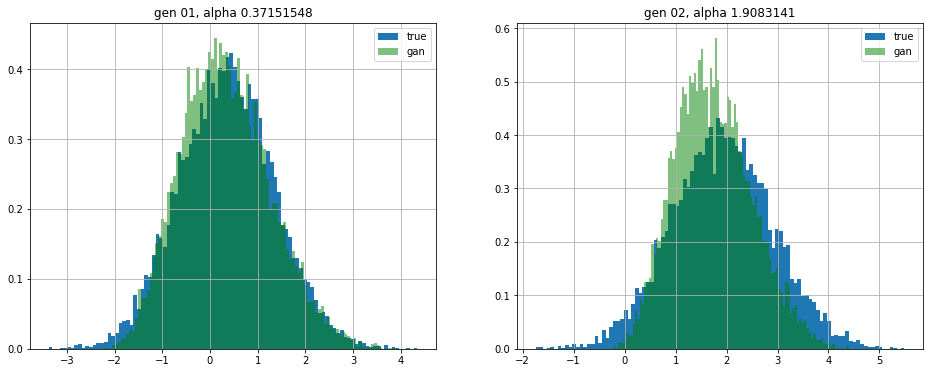

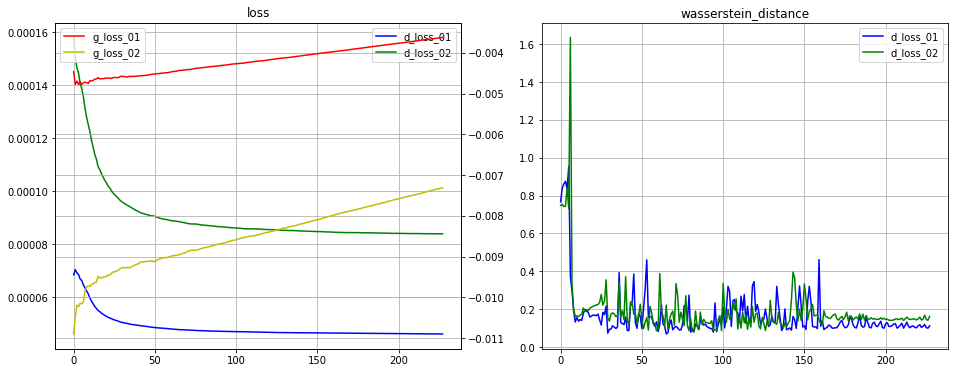

In [36]:
run_training()

In [37]:
def get_disc_losses(mode, n_samples=1000):
    alphas = np.linspace(0, 2, 100)
    losses = {"real": [], "fake": [], "combined": []}
    for alpha in alphas:
        data = torch.Tensor(np.random.normal(alpha, 1, n_samples)).reshape(-1, 1).to(device)
        alpha = torch.Tensor([alpha]*n_samples).reshape(-1, 1).to(device)
        
        loss_real = discriminator(data, alpha).mean().item()
        losses["real"].append(loss_real)
        
        noise = torch.Tensor(sample_noise(n_samples)).to(device)
        generated = generator(noise, alpha, mode=mode)
        loss_fake = discriminator(generated, alpha).mean().item()
        losses["fake"].append(loss_fake)
        
        losses["combined"].append(loss_fake-loss_real)
    return losses

In [38]:
losses_01 = get_disc_losses("01")
losses_02 = get_disc_losses("02")

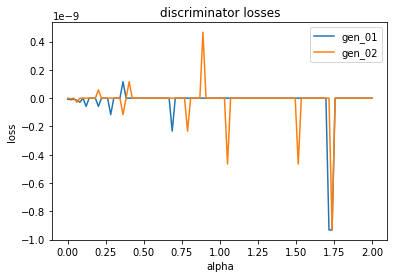

In [69]:
plt.plot(np.linspace(0, 2, 100), losses_01["combined"], label="gen_01")
plt.plot(np.linspace(0, 2, 100), losses_02["combined"], label="gen_02")
plt.title("discriminator losses")
plt.xlabel("alpha")
plt.ylabel("loss")
plt.legend()
plt.show()

In [71]:
alphas = [torch.Tensor([x]*1000).reshape(-1, 1).to(device) for x in np.linspace(0, 2, 100)]

In [72]:
noise = torch.Tensor(sample_noise(1000)).to(device)
generated_01 = [generator(noise, alpha, mode="01").detach().cpu().numpy().mean() for alpha in alphas]
generated_02 = [generator(noise, alpha, mode="02").detach().cpu().numpy().mean() for alpha in alphas]

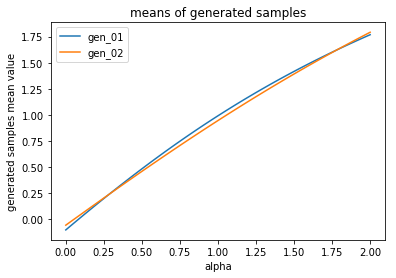

In [73]:
plt.plot(np.linspace(0, 2, 100), generated_01, label="gen_01")
plt.plot(np.linspace(0, 2, 100), generated_02, label="gen_02")
plt.title("means of generated samples")
plt.xlabel("alpha")
plt.ylabel("generated samples mean value")
plt.legend()
plt.show()

In [64]:
noise = torch.Tensor(sample_noise(1000)).to(device)
generated_01 = [generator(noise, alpha, mode="01").detach().cpu().numpy() for alpha in alphas]
generated_02 = [generator(noise, alpha, mode="02").detach().cpu().numpy() for alpha in alphas]

In [65]:
w_distances_01 = [scipy.stats.wasserstein_distance(np.squeeze(g), np.random.normal(a, 1, len(g))) for g, a in zip(generated_01, np.linspace(0, 2, 100))]
w_distances_02 = [scipy.stats.wasserstein_distance(np.squeeze(g), np.random.normal(a, 1, len(g))) for g, a in zip(generated_02, np.linspace(0, 2, 100))]

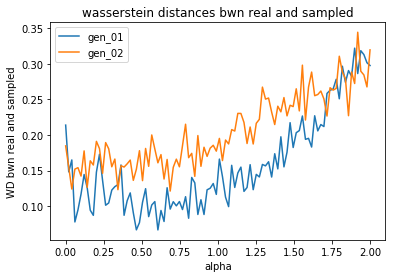

In [74]:
plt.plot(np.linspace(0, 2, 100), w_distances_01, label="gen_01")
plt.plot(np.linspace(0, 2, 100), w_distances_02, label="gen_02")
plt.title("wasserstein distances bwn real and sampled")
plt.xlabel("alpha")
plt.ylabel("WD bwn real and sampled")
plt.legend()
plt.show()